## Reproduce the BOSS cosmology results

Some notes and papers:

* https://nbodykit.readthedocs.io/en/latest/cookbook/convpower.html
* [Baryon Acoustic Oscillations](https://arxiv.org/abs/0910.5224) is a nice reference paper on the BAO feature.
* [BOSS LSS catalogs](https://www.sdss.org/dr14/spectro/lss/#BOSS)

#### Getting the data
* wget "https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASSLOWZTOT_North.fits.gz"
* wget "https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASSLOWZTOT_South.fits.gz"
* wget "https://data.sdss.org/sas/dr12/boss/lss/random0_DR12v5_CMASSLOWZTOT_North.fits.gz"
* wget "https://data.sdss.org/sas/dr12/boss/lss/random0_DR12v5_CMASSLOWZTOT_South.fits.gz"

In [1]:
#%%bash
#wget "https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASSLOWZTOT_North.fits.gz"
#wget "https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASSLOWZTOT_South.fits.gz"
#wget "https://data.sdss.org/sas/dr12/boss/lss/random0_DR12v5_CMASSLOWZTOT_North.fits.gz"
#wget "https://data.sdss.org/sas/dr12/boss/lss/random0_DR12v5_CMASSLOWZTOT_South.fits.gz"

In [2]:
import os, pdb
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from nbodykit.lab import *
from nbodykit import setup_logging, style, set_options

set_options(dask_chunk_size=1024*1024*32)
#from nbodykit.source.catalog import FITSCatalog
#from nbodykit.algorithms import SurveyData2PCF

In [4]:
plt.style.use(style.notebook)
%matplotlib inline

### Preliminaries

In [5]:
setup_logging()

In [6]:
cosmo = cosmology.Cosmology(h=0.7).match(Omega0_m=0.31)

In [8]:
datadir = os.path.join(os.getenv('IM_DATA_DIR'), 'sdss', 'dr12')

In [30]:
def subsample_data(randoms=False, nsample=None, clobber=False):
    """Read and subsample the data or randoms LSS catalog, for speed.
    
    Here, we select objects with z=0.4-0.6 (see Alam+17, Table 2).
    
    """
    import fitsio
    import dask.array as da    
    
    if randoms:
        dataset = 'DR12v5-randoms'
        columns = ['RA', 'DEC', 'Z', 'WEIGHT_FKP',]
        infile = os.path.join(datadir, 'random0_DR12v5_CMASSLOWZTOT_North.fits.gz')
        outfile = os.path.join(datadir, 'subset_random0_DR12v5_CMASSLOWZTOT_North.fits')
    else:
        dataset = 'DR12v5'
        columns = ['RA', 'DEC', 'Z', 'WEIGHT_FKP', 'WEIGHT_CP', 'WEIGHT_NOZ', 'WEIGHT_SYSTOT',]
        infile = os.path.join(datadir, 'galaxy_DR12v5_CMASSLOWZTOT_North.fits.gz')
        outfile = os.path.join(datadir, 'subset_galaxy_DR12v5_CMASSLOWZTOT_North.fits')
        
    if not os.path.exists(outfile) or clobber:
        finfo = fitsio.FITS(infile)
        
        # Read a subset of the data.
        if nsample is None:
            rows = None
        else:
            rows = np.arange(0, finfo[1].get_nrows(), nsample)
            
        data = finfo[1].read(upper=True, columns=columns, rows=rows)
        #data = FITSCatalog(infile)
        print('Read {} / {} rows from {}'.format(len(data), finfo[1].get_nrows(), infile))
    
        keep = (data['Z'] > 0.4) * (data['Z'] < 0.6)
        nobj = np.sum(keep)
        print('Keeping {} / {} galaxies with 0.4<z<0.6.'.format(nobj, len(data)))
        _subdata = data[keep]
        #subdata = da.from_array(data[keep], chunks=np.sum(keep))
    
        # Add Cartesian coordinates
        xyzpos = transform.SkyToCartesian(_subdata['RA'], _subdata['DEC'], _subdata['Z'], cosmo=cosmo).compute()
        columns += ['POSITION']
        
        # This doesn't work!
        #np.lib.recfunctions.append_fields(_subdata, 'POSITION', xyzpos, dtypes=np.dtype(('POSITION', '>f8', (3,))))

        subdata = np.empty(_subdata.shape, dtype=np.dtype( _subdata.dtype.descr + [('POSITION', xyzpos.dtype, (3, ))] ))
        for ff in _subdata.dtype.fields:
            subdata[ff] = _subdata[ff]
        subdata['POSITION'] = xyzpos
        del _subdata
        
        print('Writing {} rows to {}'.format(nobj, outfile))
        #subdata.save(outfile, columns, dataset=dataset)
        fitsio.write(outfile, subdata, clobber=True)
        del subdata
    
    print('Reading {}'.format(outfile))
    out = FITSCatalog(outfile)
        
        #if not randoms:
        #    # Read and compute the statistical weight from Anderson+12, equation 18:
        #    out = FITSCatalog(outfile)
        #    out['Weight'] = out['WEIGHT_SYSTOT'] * ( out['WEIGHT_NOZ'] + out['WEIGHT_CP'] - 1 )
    
    return out

In [9]:
def subsample2_data(randoms=False, nsample=1, clobber=False):
    """Read and subsample the data or randoms LSS catalog, for speed.
    
    Here, we select objects with z=0.4-0.6 (see Alam+17, Table 2).
    
    """
    import fitsio

    if randoms:
        dataset = 'DR12v5-randoms'
        columns = ['RA', 'DEC', 'Z', 'WEIGHT_FKP',]
        infile = os.path.join(datadir, 'random0_DR12v5_CMASSLOWZTOT_North.fits.gz')
        outfile = os.path.join(datadir, 'random0_DR12v5_CMASSLOWZTOT_North')
    else:
        dataset = 'DR12v5'
        columns = ['RA', 'DEC', 'Z', 'WEIGHT_FKP', 'WEIGHT_CP', 'WEIGHT_NOZ', 'WEIGHT_SYSTOT',]
        infile = os.path.join(datadir, 'galaxy_DR12v5_CMASSLOWZTOT_North.fits.gz')
        outfile = os.path.join(datadir, 'galaxy_DR12v5_CMASSLOWZTOT_North')
    try:
        data = BigFileCatalog(outfile, dataset='samples')
    except:
        clobber = True
        
    if clobber: # convert to bigfile if not yet.
        data = ArrayCatalog(fitsio.read(infile, columns=columns))
        # if data doesn't fit into memory, use FITSCatalog(infile)
        data.save(outfile, columns=columns, dataset='samples')
    
    data = BigFileCatalog(outfile, dataset='samples')
    
    if nsample is not None:
        data = data[::nsample]
        
    keep = (data['Z'] > 0.4) & (data['Z'] < 0.6)
    print(keep.sum().compute())
    out = data[keep]
        
    out['POSITION'] = transform.SkyToCartesian(out['RA'], out['DEC'], out['Z'], cosmo=cosmo)
    
    return out

In [10]:
#%time data = subsample_data(nsample=32, clobber=True)

In [11]:
%time data = subsample2_data(nsample=1, clobber=True)

[ 000120.88 ]   0: 01-03 19:04  CatalogSource   INFO     Extra arguments to FileType: ('/Users/ioannis/research/data/sdss/dr12/galaxy_DR12v5_CMASSLOWZTOT_North',) {'dataset': 'samples'}


500872
CPU times: user 2.18 s, sys: 479 ms, total: 2.66 s
Wall time: 2.67 s


In [14]:
%time random = subsample2_data(nsample=1, randoms=True, clobber=False)

[ 000272.21 ]   0: 01-03 19:07  CatalogSource   INFO     Extra arguments to FileType: ('/Users/ioannis/research/data/sdss/dr12/random0_DR12v5_CMASSLOWZTOT_North',) {'dataset': 'samples'}


26017384
CPU times: user 48.6 s, sys: 22.4 s, total: 1min 10s
Wall time: 1min 10s


In [15]:
#%time random = subsample_data(randoms=True, nsample=32, clobber=True)

In [17]:
print('Data columns: {}'.format(data.columns))
print('Random columns: {}'.format(random.columns))

Data columns: ['DEC', 'POSITION', 'RA', 'Selection', 'Value', 'WEIGHT_CP', 'WEIGHT_FKP', 'WEIGHT_NOZ', 'WEIGHT_SYSTOT', 'Weight', 'Z']
Random columns: ['DEC', 'POSITION', 'RA', 'Selection', 'Value', 'WEIGHT_FKP', 'Weight', 'Z']


In [145]:
#rr = (data['WEIGHT_SYSTOT'] * (data['WEIGHT_NOZ'] + data['WEIGHT_CP'] - 1)).compute()
#data.Weight

### Generate n(z) for the data.

In [18]:
def get_nofz(totarea=9329, north=True):
    """Build n(z) for the data.  The total area is from Alam+17, Table 2.
    
    """
    from scipy.interpolate import InterpolatedUnivariateSpline
    
    if north:
        area = totarea * 5.3 / 7.3
    else:
        area = totarea * 2.0 / 7.3
    
    # compute n(z) from the randoms
    fsky = area / ( 4 * np.pi * (180 / np.pi)**2 ) # sky fraction from Alam+17
    zhist = RedshiftHistogram(random, fsky, cosmo, redshift='Z')
    
    # re-normalize to the total size of the data catalog
    alpha = 1.0 * data.csize / random.csize
    print('Renormalization factor = {:.5f}'.format(alpha))
    zhist.nbar *= alpha
    
    # Compute the interpolator we'll use below.
    nofz = InterpolatedUnivariateSpline(zhist.bin_centers, zhist.nbar)
    
    return zhist, nofz

In [19]:
def qa_zhist(zhist):
    fig, ax = plt.subplots()
    ax.plot(zhist.bin_centers, zhist.nbar)
    ax.set_xlabel(r'$z$', fontsize=16)
    ax.set_ylabel(r'$n(z)$ $[h^{3} \mathrm{Mpc}^{-3}]$', fontsize=16)    

In [20]:
%time zhist, nofz = get_nofz()

[ 000359.26 ]   0: 01-03 19:08  RedshiftHistogram INFO     using Scott's rule to determine optimal binning; h = 5.99e-04, N_bins = 334
[ 000362.88 ]   0: 01-03 19:08  RedshiftHistogram INFO     using cosmology {'output': 'vTk dTk mPk', 'extra metric transfer functions': 'y', 'n_s': 0.9667, 'gauge': 'synchronous', 'N_ur': 2.0328, 'h': 0.7, 'T_cmb': 2.7255, 'N_ncdm': 1, 'P_k_max_h/Mpc': 10.0, 'z_max_pk': 100.0, 'Omega_b': 0.04775550899153668, 'Omega_cdm': 0.2609299279412303, 'm_ncdm': [0.06]} to compute volume in units of (Mpc/h)^3
[ 000362.88 ]   0: 01-03 19:08  RedshiftHistogram INFO     sky fraction used in volume calculation: 0.1642


Renormalization factor = 0.01925
CPU times: user 4.84 s, sys: 1.65 s, total: 6.49 s
Wall time: 5.62 s


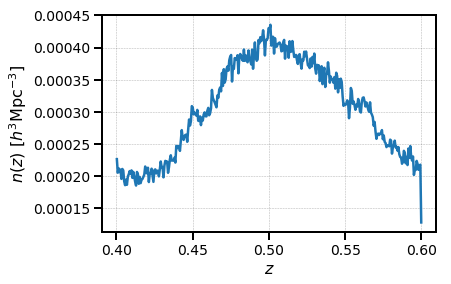

In [21]:
qa_zhist(zhist)

### Instantiate an FKPCatalog object by combining the data and randoms.

In [22]:
data['NZ'] = nofz(data['Z'])
random['NZ'] = nofz(random['Z'])
data['FKPWeight'] = 1.0 / (1 + data['NZ'] * 2e4)
random['FKPWeight'] = 1.0 / (1 + random['NZ'] * 2e4)

data['Weight'] = (data['WEIGHT_SYSTOT'] * (data['WEIGHT_NOZ'] + data['WEIGHT_CP'] - 1)).compute()
random['Weight'] = np.ones(len(random))

fkp = FKPCatalog(data, random)

In [23]:
data['NZ'].compute()

array([0.00030718, 0.00030129, 0.00041125, ..., 0.00027166, 0.00020825,
       0.00018999])

In [26]:
#fkp['data/FKPWeight'].compute(), data['WEIGHT_FKP'].compute()
data['NZ'].compute()

array([0.00030718, 0.00030129, 0.00041125, ..., 0.00027166, 0.00020825,
       0.00018999])

In [143]:
data['Weight'].compute()

array([0.9976136, 1.0060105, 0.9926974, ..., 0.9762613, 1.0764927,
       0.9659687], dtype=float32)

In [27]:
%time mesh = fkp.to_mesh(Nmesh=256, nbar='NZ', comp_weight='Weight', fkp_weight='FKPWeight', position='POSITION')

[ 037681.12 ]   0: 01-04 05:30  FKPCatalog      INFO     cartesian coordinate range: [-1537.92027082 -1419.69646037   -96.66655346] : [-101.95582015 1347.59487189 1432.35074652]
[ 037681.12 ]   0: 01-04 05:30  FKPCatalog      INFO     BoxSize = [1465. 2823. 1560.]
[ 037681.12 ]   0: 01-04 05:30  FKPCatalog      INFO     BoxCenter = [-819.93804548  -36.05079424  667.84209653]


CPU times: user 34.9 s, sys: 9.19 s, total: 44.1 s
Wall time: 37.3 s


In [31]:
field = mesh.paint()

[ 037933.62 ]   0: 01-04 05:34  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 500872 
[ 037934.36 ]   0: 01-04 05:34  CatalogMesh     INFO     painted 500872 out of 500872 objects to mesh
[ 037934.37 ]   0: 01-04 05:34  CatalogMesh     INFO     painted 500872 out of 500872 objects to mesh
[ 037934.37 ]   0: 01-04 05:34  CatalogMesh     INFO     mean particles per cell is 0.00443252
[ 037934.37 ]   0: 01-04 05:34  CatalogMesh     INFO     sum is 74365.4 
[ 037934.37 ]   0: 01-04 05:34  FKPCatalogMesh  INFO     data painted.
[ 037934.41 ]   0: 01-04 05:34  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 26017384 
[ 037946.47 ]   0: 01-04 05:35  CatalogMesh     INFO     painted 4194304 out of 26017384 objects to mesh
[ 037946.47 ]   0: 01-04 05:35  CatalogMesh     INFO     Chunk 4194304 ~ 8388608 / 26017384 
[ 037957.60 ]   0: 01-04 05:35  CatalogMesh     INFO     painted 8388608 out of 26017384 objects to mesh
[ 037957.60 ]   0: 01-04 05:35  CatalogMesh     INFO     Chunk 8388608 ~ 12582912 

In [30]:
plt.imshow(field[...].sum(axis=0))

NameError: name 'field' is not defined

In [28]:
%time r = ConvolvedFFTPower(mesh, poles=[0, 2, 4])

[ 037755.63 ]   0: 01-04 05:31  ConvolvedFFTPower INFO     using compensation function CompensateCICShotnoise for source 'first'
[ 037755.63 ]   0: 01-04 05:31  ConvolvedFFTPower INFO     using compensation function CompensateCICShotnoise for source 'second'
[ 037769.66 ]   0: 01-04 05:32  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 500872 
[ 037770.21 ]   0: 01-04 05:32  CatalogMesh     INFO     painted 500872 out of 500872 objects to mesh
[ 037770.22 ]   0: 01-04 05:32  CatalogMesh     INFO     painted 500872 out of 500872 objects to mesh
[ 037770.22 ]   0: 01-04 05:32  CatalogMesh     INFO     mean particles per cell is 0.00443252
[ 037770.23 ]   0: 01-04 05:32  CatalogMesh     INFO     sum is 74365.4 
[ 037770.23 ]   0: 01-04 05:32  FKPCatalogMesh  INFO     data painted.
[ 037770.27 ]   0: 01-04 05:32  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 26017384 
[ 037782.36 ]   0: 01-04 05:32  CatalogMesh     INFO     painted 4194304 out of 26017384 objects to mesh
[ 037782.36 ]   0: 01

CPU times: user 2min 8s, sys: 47.7 s, total: 2min 55s
Wall time: 2min 31s


[]

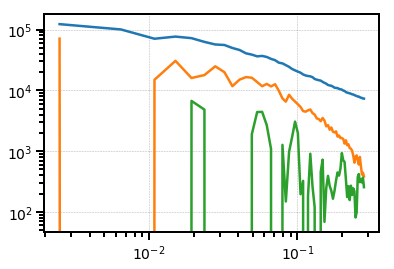

In [149]:
plt.plot(r.poles['k'], r.poles['power_0'])
plt.plot(r.poles['k'], r.poles['power_2'])
plt.plot(r.poles['k'], r.poles['power_4'])
plt.loglog()

### Compute the 2-point correlation function

In [40]:
pimax = 40
edges = np.arange(1, 41, 1)
edges

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40])

In [42]:
xi = SurveyData2PCF('projected', data, random, edges, cosmo=cosmo, pimax=pimax, 
                    redshift='Z', weight='Weight', show_progress=True, **{'nthreads': 4})

[ 038908.75 ]   0: 01-04 05:51  SurveyData2PCF  INFO     computing randoms1 - randoms2 pair counts
[ 038908.75 ]   0: 01-04 05:51  SurveyDataPairCount INFO     using cpu grid decomposition: (1, 1, 1)
[ 038943.02 ]   0: 01-04 05:51  SurveyDataPairCount INFO     position variable range on rank 0 (max, min) = [-100.5198557  1350.36216323 1433.87976382], [-1539.35623527 -1422.46375171   -98.19557076]
[ 038944.85 ]   0: 01-04 05:51  SurveyDataPairCount INFO     Load balance done
[ 038955.97 ]   0: 01-04 05:51  SurveyDataPairCount INFO     correlating 26017384 x 26017384 objects in total
[ 038955.97 ]   0: 01-04 05:51  SurveyDataPairCount INFO     correlating A x B = 26017384 x 26017384 objects (median) per rank
[ 038955.98 ]   0: 01-04 05:51  SurveyDataPairCount INFO     min A load per rank = 26017384
[ 038955.98 ]   0: 01-04 05:51  SurveyDataPairCount INFO     max A load per rank = 26017384
[ 038955.98 ]   0: 01-04 05:51  SurveyDataPairCount INFO     (even distribution would result in 2601

RuntimeError: calling the function 'Corrfunc.mocks.DDrppi_mocks.DDrppi_mocks' failed, likely due to issues with input data/parameters. Open at issue at https://github.com/bccp/nbodykit/issues for further help.
exception: RuntimeError occurred
stdout: 
stderr: Received signal = `Interrupt: 2' (signo = 2). Aborting 
